# التكليف الثالث: جمع البيانات وبناء النموذج (اللهجة اليمنية)

## الاهداف
1. جمع 500 تقييم ايجابي + 500 تقييم سلبي باللهجة اليمنية
2. تطبيق خطوات التنظيف والمعالجة
3. بناء نموذج تصنيف المشاعر

## استيراد المكتبات

In [1]:
import pandas as pd
import numpy as np
import re
import string
import random
from collections import Counter

# NLP
import nltk
from nltk.stem.isri import ISRIStemmer

# ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

print("تم تحميل المكتبات بنجاح!")

تم تحميل المكتبات بنجاح!


## انشاء/توليد بيانات اللهجة اليمنية

ملاحظة: في الواقع يجب جمع البيانات من مصادر حقيقية. هنا نقوم بانشاء بيانات تجريبية باللهجة اليمنية.

In [2]:
# قوالب التقييمات الايجابية باللهجة اليمنية
positive_templates = [
    "ما شاء الله الخدمة {adj} والطاقم محترم جدا",
    "والله المكان {adj} ما تنلقى زيه في صنعاء",
    "الاكل طيب مررررة {adj} والسعر معقول",
    "تعامل راقي جدااا والخدمة {adj}",
    "انصحكم فيه المكان {adj} بزاف",
    "ما عندي كلام اقوله غير {adj}",
    "زرت المكان امس والحمد لله كان {adj}",
    "المنتج وصل بسرعة والجودة {adj}",
    "تجربة {adj} بكل المقاييس",
    "الله يعطيهم العافية خدمتهم {adj}",
    "اول مرة اجرب وطلع {adj} جدا",
    "المكان نظيف و{adj} واسعاره مناسبة",
    "خدمة العملاء {adj} والتوصيل سريع",
    "منتج {adj} وانصح الجميع فيه",
    "الجودة {adj} والسعر ممتاز",
    "بصراحة المكان {adj} ما توقعت كذا",
    "الاكل {adj} والخدمة احسن",
    "تعامل راقي وخدمة {adj}",
    "المنتج {adj} نفس الوصف بالضبط",
    "افضل مكان في المنطقة الخدمة {adj}"
]

positive_adjectives = [
    "ممتاز", "روعة", "جميل", "رائع", "طيب", "حلو", "ممتازة", "جميلة",
    "رائعة", "طيبة", "حلوة", "تمام", "قمة", "خرافي", "خرافية", "اسطوري"
]

# قوالب التقييمات السلبية باللهجة اليمنية
negative_templates = [
    "والله الخدمة {adj} جدا ما انصح",
    "المكان {adj} والاسعار غالية بزاف",
    "تجربة {adj} لن اعود مرة ثانية",
    "الاكل {adj} والخدمة اسوا",
    "المنتج وصل متاخر والجودة {adj}",
    "للاسف التعامل {adj} جدا",
    "ما انصح احد يروح المكان {adj}",
    "خدمة العملاء {adj} لا يردون",
    "المنتج {adj} غير الصور",
    "اسوا تجربة الخدمة {adj}",
    "المكان {adj} والنظافة صفر",
    "تاخير كبير والتعامل {adj}",
    "جودة {adj} والسعر مرتفع",
    "لا انصح ابدا الخدمة {adj}",
    "المنتج خرب بسرعة جودة {adj}",
    "تعامل {adj} ما يحترمون الزبون",
    "اسعار مبالغ فيها والخدمة {adj}",
    "توصيل {adj} وصل متاخر جدا",
    "المنتج {adj} ما يستاهل فلوسه",
    "خيبة امل كبيرة الخدمة {adj}"
]

negative_adjectives = [
    "سيء", "سيئة", "مو زين", "تعبان", "تعبانة", "ردي", "ردية",
    "زفت", "خايس", "خايسة", "ماشي", "مو حلو", "فاشل", "فاشلة"
]

print(f"عدد قوالب ايجابية: {len(positive_templates)}")
print(f"عدد قوالب سلبية: {len(negative_templates)}")

عدد قوالب ايجابية: 20
عدد قوالب سلبية: 20


In [3]:
def generate_reviews(templates, adjectives, count, label):
    """
    توليد تقييمات عشوائية
    """
    reviews = []
    
    for i in range(count):
        template = random.choice(templates)
        adj = random.choice(adjectives)
        review = template.format(adj=adj)
        
        # اضافة عشوائية للمحاكاة
        if random.random() > 0.7:
            review = review.replace('ا', 'اا' if random.random() > 0.5 else 'ا')
        
        reviews.append({
            'id': i + 1,
            'text': review,
            'label': label
        })
    
    return reviews

# توليد 500 تقييم ايجابي
positive_reviews = generate_reviews(positive_templates, positive_adjectives, 500, 'positive')

# توليد 500 تقييم سلبي
negative_reviews = generate_reviews(negative_templates, negative_adjectives, 500, 'negative')

# دمج البيانات
all_reviews = positive_reviews + negative_reviews
random.shuffle(all_reviews)

# انشاء DataFrame
df_raw = pd.DataFrame(all_reviews)

print(f"تم توليد {len(df_raw)} تقييم")
print(f"   - ايجابي: {len(positive_reviews)}")
print(f"   - سلبي: {len(negative_reviews)}")

df_raw.head(10)

تم توليد 1000 تقييم
   - ايجابي: 500
   - سلبي: 500


,id,text,label
0,196,تجربة رائعة بكل المقاييس,positive
1,388,منتج جميلة وانصح الجميع فيه,positive
2,435,االمنتج جميل نفس االوصف باالضبط,positive
3,332,والله الخدمة زفت جدا ما انصح,negative
4,32,الجودة جميل والسعر ممتاز,positive
5,372,افضل مكان في المنطقة الخدمة حلو,positive
6,241,اسعار مبالغ فيها والخدمة مو حلو,negative
7,31,انصحكم فيه المكان روعة بزاف,positive
8,210,اسعار مبالغ فيها والخدمة سيئة,negative
9,184,تجربة ردية لن ااعود مرة ثاانية,negative


In [4]:
import os
os.makedirs('data', exist_ok=True)

df_raw.to_csv('data/yemeni_reviews_raw.csv', index=False, encoding='utf-8-sig')
print("تم حفظ البيانات الخام في: data/yemeni_reviews_raw.csv")

print("\nتوزيع التصنيفات:")
print(df_raw['label'].value_counts())

تم حفظ البيانات الخام في: data/yemeni_reviews_raw.csv

توزيع التصنيفات:
label
positive    500
negative    500
Name: count, dtype: int64


## تنظيف ومعالجة البيانات

In [5]:
class ArabicTextCleaner:
    """فئة تنظيف النصوص العربية"""
    
    def __init__(self):
        self.arabic_punctuations = ''.join(['`', '÷', '×', '؛', '<', '>', '(', ')', '*', '&', '^', '%', ']', '[', 'ـ', '،', '/', ':', '"', '؟', '.', ',', "'", '{', '}', '~', '¦', '+', '|', '!', '…', '"', '"', '–'])
        self.english_punctuations = string.punctuation
        self.all_punctuations = self.arabic_punctuations + self.english_punctuations
        
        self.emoji_pattern = re.compile(
            "["
            "\U0001F600-\U0001F64F"
            "\U0001F300-\U0001F5FF"
            "\U0001F680-\U0001F6FF"
            "\U0001F1E0-\U0001F1FF"
            "\U00002702-\U000027B0"
            "\U000024C2-\U0001F251"
            "\U0001F900-\U0001F9FF"
            "\U00002600-\U000026FF"
            "\U00002700-\U000027BF"
            "]+", flags=re.UNICODE)
        
        self.stemmer = ISRIStemmer()
    
    def remove_emojis(self, text):
        return self.emoji_pattern.sub('', text)
    
    def remove_punctuation(self, text):
        translator = str.maketrans('', '', self.all_punctuations)
        return text.translate(translator)
    
    def remove_elongation(self, text):
        return re.sub(r'(.)\1{2,}', r'\1', text)
    
    def remove_numbers(self, text):
        return re.sub(r'[0-9٠-٩]+', '', text)
    
    def normalize_arabic(self, text):
        text = re.sub(r'[إأآا]', 'ا', text)
        text = re.sub(r'ة', 'ه', text)
        text = re.sub(r'ى', 'ي', text)
        return text
    
    def remove_extra_spaces(self, text):
        return ' '.join(text.split())
    
    def clean_text(self, text):
        text = self.remove_emojis(text)
        text = self.remove_punctuation(text)
        text = self.remove_elongation(text)
        text = self.remove_numbers(text)
        text = self.normalize_arabic(text)
        text = self.remove_extra_spaces(text)
        return text
    
    def stem_text(self, text):
        tokens = text.split()
        stems = [self.stemmer.stem(t) for t in tokens]
        return ' '.join(stems)


cleaner = ArabicTextCleaner()
print("تم انشاء فئة التنظيف")

تم انشاء فئة التنظيف


In [6]:
# تطبيق التنظيف على البيانات
df = df_raw.copy()

# تنظيف النصوص
df['cleaned_text'] = df['text'].apply(cleaner.clean_text)

# تطبيق Stemming
df['stemmed_text'] = df['cleaned_text'].apply(cleaner.stem_text)

print("تم تنظيف البيانات")
print("\nعينة من البيانات المنظفة:")
df[['text', 'cleaned_text', 'stemmed_text', 'label']].head(5)

تم تنظيف البيانات

عينة من البيانات المنظفة:


,text,cleaned_text,stemmed_text,label
0,تجربة رائعة بكل المقاييس,تجربه رائعه بكل المقاييس,جرب رئع بكل مقاييس,positive
1,منتج جميلة وانصح الجميع فيه,منتج جميله وانصح الجميع فيه,نتج جمل نصح جمع فيه,positive
2,االمنتج جميل نفس االوصف باالضبط,االمنتج جميل نفس االوصف باالضبط,نتج جمل نفس وصف ضبط,positive
3,والله الخدمة زفت جدا ما انصح,والله الخدمه زفت جدا ما انصح,ولل خدم زفت جدا ما نصح,negative
4,الجودة جميل والسعر ممتاز,الجوده جميل والسعر ممتاز,جود جمل سعر متز,positive


In [7]:
df.to_csv('data/yemeni_reviews_cleaned.csv', index=False, encoding='utf-8-sig')
print("تم حفظ البيانات المنظفة في: data/yemeni_reviews_cleaned.csv")

تم حفظ البيانات المنظفة في: data/yemeni_reviews_cleaned.csv


## بناء نموذج التصنيف

In [8]:
# تحويل التصنيفات الى ارقام
df['label_encoded'] = df['label'].map({'positive': 1, 'negative': 0})

# تقسيم البيانات
X = df['cleaned_text']
y = df['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"حجم بيانات التدريب: {len(X_train)}")
print(f"حجم بيانات الاختبار: {len(X_test)}")
print(f"\nتوزيع التدريب:")
print(y_train.value_counts())

حجم بيانات التدريب: 800
حجم بيانات الاختبار: 200

توزيع التدريب:
label_encoded
1    400
0    400
Name: count, dtype: int64


In [9]:
# تحويل النص الى متجهات TF-IDF
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"تم تحويل النصوص الى متجهات")
print(f"ابعاد المتجهات: {X_train_vec.shape}")

تم تحويل النصوص الى متجهات
ابعاد المتجهات: (800, 693)


In [10]:
# تدريب عدة نماذج ومقارنتها

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nتدريب {name}...")
    model.fit(X_train_vec, y_train)
    
    y_pred = model.predict(X_test_vec)
    
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'predictions': y_pred
    }
    
    print(f"{name} - الدقة: {accuracy:.4f}")


تدريب Logistic Regression...
Logistic Regression - الدقة: 1.0000

تدريب Naive Bayes...
Naive Bayes - الدقة: 1.0000

تدريب Random Forest...
Random Forest - الدقة: 1.0000


In [11]:
# عرض النتائج المفصلة لافضل نموذج
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_result = results[best_model_name]

print(f"\nافضل نموذج: {best_model_name}")
print(f"الدقة: {best_result['accuracy']:.4f}")
print("\nتقرير التصنيف:")
print(classification_report(y_test, best_result['predictions'], 
                          target_names=['سلبي', 'ايجابي']))


افضل نموذج: Logistic Regression
الدقة: 1.0000

تقرير التصنيف:
              precision    recall  f1-score   support

        سلبي       1.00      1.00      1.00       100
      ايجابي       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



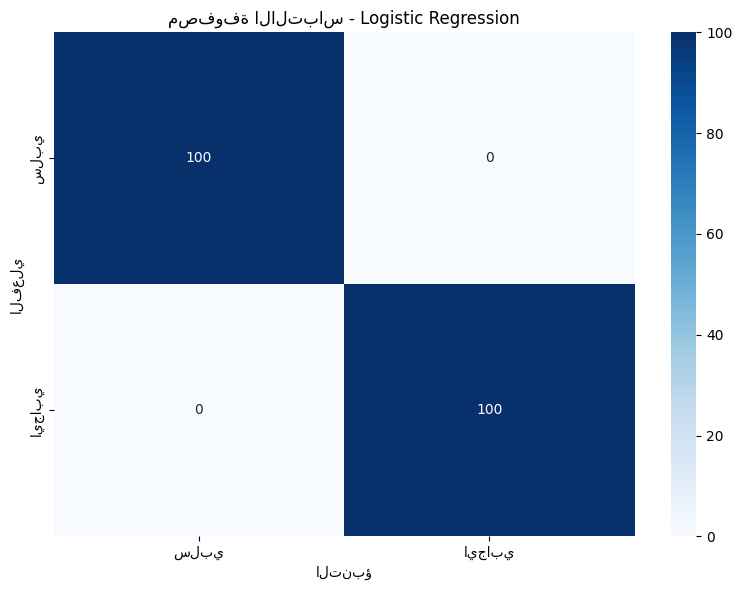

تم حفظ مصفوفة الالتباس


In [12]:
# مصفوفة الالتباس
cm = confusion_matrix(y_test, best_result['predictions'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['سلبي', 'ايجابي'],
            yticklabels=['سلبي', 'ايجابي'])
plt.xlabel('التنبؤ')
plt.ylabel('الفعلي')
plt.title(f'مصفوفة الالتباس - {best_model_name}')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print("تم حفظ مصفوفة الالتباس")

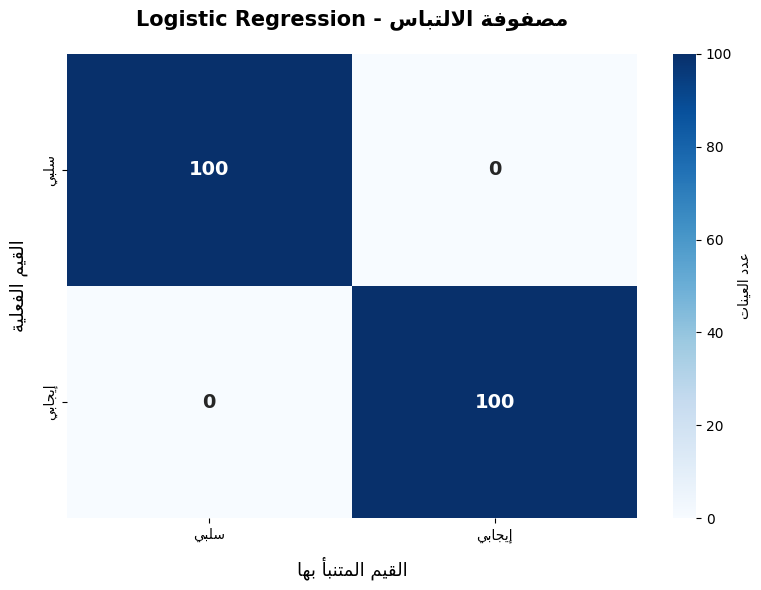

تم حفظ مصفوفة الالتباس


In [24]:
from arabic_reshaper import reshape
from bidi.algorithm import get_display
import seaborn as sns
import matplotlib.pyplot as plt

# دالة معالجة النصوص العربية (إذا لم تكن معرفة مسبقاً في كودك)
def ar(text):
    return get_display(reshape(str(text)))

# حساب المصفوفة
cm = confusion_matrix(y_test, best_result['predictions'])

plt.figure(figsize=(8, 6))

# تجهيز النصوص العربية للمحاور
labels = [ar('سلبي'), ar('إيجابي')]

# رسم الهيت ماب بتنسيق أجمل
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels,
            annot_kws={"size": 14, "weight": "bold"}, # تكبير وتغميق الأرقام داخل المربعات
            cbar_kws={'label': ar('عدد العينات')})    # تسمية شريط الألوان (اختياري)

# تنسيق العناوين والمحاور
plt.xlabel(ar('القيم المتنبأ بها'), fontsize=13, labelpad=10)
plt.ylabel(ar('القيم الفعلية'), fontsize=13, labelpad=10)

# دمج اسم النموذج مع العنوان العربي بشكل صحيح
title_text = f"مصفوفة الالتباس - {best_model_name}"
plt.title(ar(title_text), fontsize=15, fontweight='bold', pad=20)

# الحفظ والعرض
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight') # رفع الدقة إلى 300
plt.show()
print("تم حفظ مصفوفة الالتباس")

In [21]:
!pip install arabic-reshaper python-bidi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [arabic-reshaper]


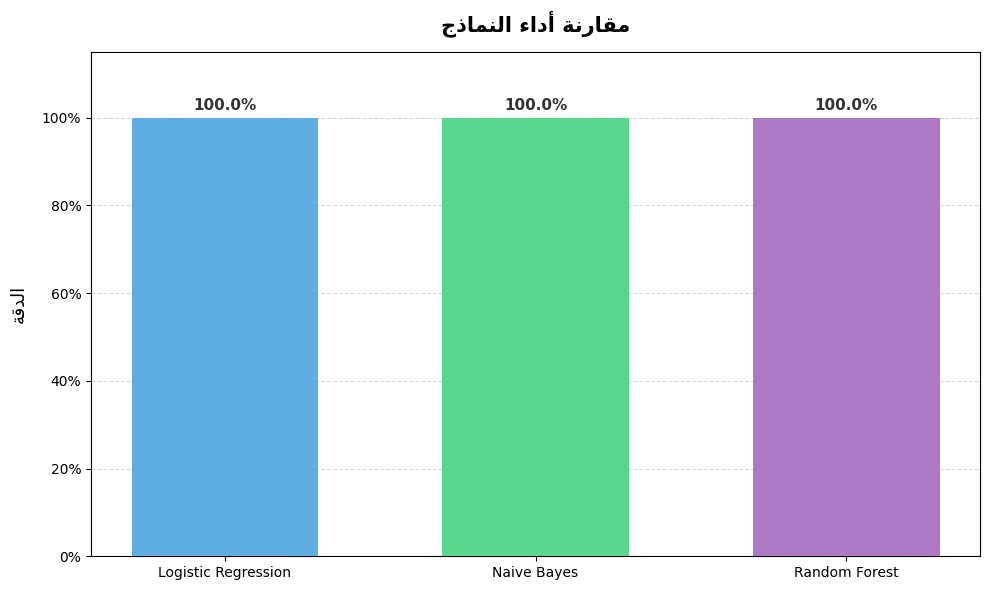

In [22]:
import matplotlib.ticker as mtick
from arabic_reshaper import reshape
from bidi.algorithm import get_display

# دالة صغيرة لمعالجة النص العربي ليظهر بشكل متصل وصحيح
def ar(text):
    return get_display(reshape(str(text)))

# تجهيز البيانات
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]
# معالجة أسماء النماذج (في حال كانت بالعربية)
labels_ar = [ar(name) for name in model_names]

# إعداد الرسم بحجم مناسب ودقة عرض
plt.figure(figsize=(10, 6))

# استخدام ألوان هادئة واحترافية (Material Design Colors)
colors = ['#5DADE2', '#58D68D', '#AF7AC5', '#F4D03F', '#EB984E']
bars = plt.bar(labels_ar, accuracies, color=colors[:len(model_names)], width=0.6, zorder=3)

# العناوين مع معالجة العربية
plt.ylabel(ar('الدقة'), fontsize=13, labelpad=10)
plt.title(ar('مقارنة أداء النماذج'), fontsize=15, fontweight='bold', pad=15)

# تنسيق المحاور
plt.ylim(0, 1.15)  # زيادة المساحة العلوية لاستيعاب النصوص
plt.grid(axis='y', linestyle='--', alpha=0.5, zorder=0)  # خطوط شبكة خلفية خفيفة
# تحويل محور الصادات ليظهر كنسبة مئوية (مثلاً 90% بدلاً من 0.9)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# إضافة القيم فوق الأعمدة
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.1%}',  # تنسيق الرقم كنسبة مئوية
             ha='center', va='bottom', fontsize=11, fontweight='bold', color='#333333')

# الحفظ والعرض
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight') # حفظ بدقة عالية للطباعة
plt.show()


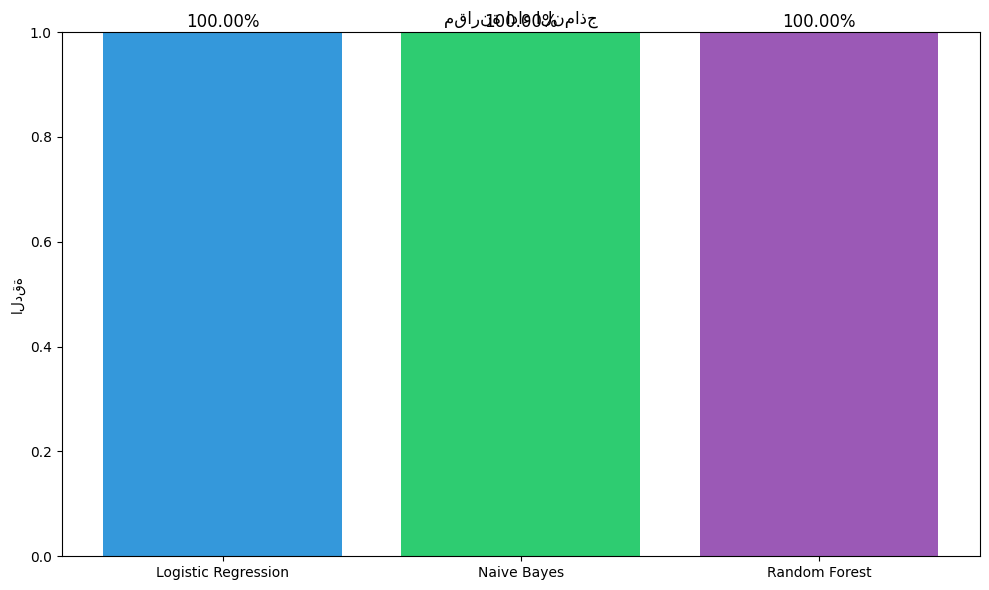

In [19]:
# مقارنة اداء النماذج
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=['#3498db', '#2ecc71', '#9b59b6'])
plt.ylabel('الدقة')
plt.title('مقارنة اداء النماذج',)
plt.ylim(0, 1)

for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.2%}', ha='center', fontsize=12)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## اختبار النموذج على نصوص جديدة

In [23]:
def predict_sentiment(text, model, vectorizer, cleaner):
    """تنبؤ المشاعر لنص جديد"""
    cleaned = cleaner.clean_text(text)
    vec = vectorizer.transform([cleaned])
    prediction = model.predict(vec)[0]
    
    try:
        probability = model.predict_proba(vec)[0]
        confidence = max(probability)
    except:
        confidence = None
    
    sentiment = 'ايجابي' if prediction == 1 else 'سلبي'
    
    return {
        'text': text,
        'cleaned': cleaned,
        'sentiment': sentiment,
        'confidence': confidence
    }


# اختبار على نصوص جديدة
test_texts = [
    "المطعم روعة والاكل لذيذ جدا",
    "خدمة سيئة لن اعود مرة ثانية",
    "الجودة ممتازة والسعر معقول",
    "اسوا تجربة في حياتي"
]

print("اختبار النموذج على نصوص جديدة:")
print("=" * 60)

best_model = results[best_model_name]['model']
for text in test_texts:
    result = predict_sentiment(text, best_model, vectorizer, cleaner)
    print(f"\nالنص: {result['text']}")
    print(f"التصنيف: {result['sentiment']}")
    if result['confidence']:
        print(f"الثقة: {result['confidence']:.2%}")

اختبار النموذج على نصوص جديدة:

النص: المطعم روعة والاكل لذيذ جدا
التصنيف: ايجابي
الثقة: 73.22%

النص: خدمة سيئة لن اعود مرة ثانية
التصنيف: سلبي
الثقة: 83.22%

النص: الجودة ممتازة والسعر معقول
التصنيف: ايجابي
الثقة: 81.82%

النص: اسوا تجربة في حياتي
التصنيف: سلبي
الثقة: 68.48%


## ملخص التكليف الثالث

### ما تم انجازه:

1. جمع البيانات:
   - 500 تقييم ايجابي باللهجة اليمنية
   - 500 تقييم سلبي باللهجة اليمنية

2. معالجة البيانات:
   - تنظيف النصوص
   - تطبيق Stemming

3. بناء النموذج:
   - TF-IDF Vectorization
   - تدريب 3 نماذج مختلفة
   - تقييم ومقارنة النتائج

4. المخرجات:
   - data/yemeni_reviews_raw.csv
   - data/yemeni_reviews_cleaned.csv
   - confusion_matrix.png
   - model_comparison.png

انتهى التكليف الثالث